# Prevedere l'età del granchio in base ai suoi attributi fisici

Progetto di Programmazione di Applicazioni Data Intensive - 2023/2024

**Realizzato da:** Simone Bollini  simone.bollini@studio.unibo.it mat. 0000

In [448]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

In [449]:
# sono eseguiti quì tutti gli import necessari da scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

In [450]:
_RANDOM_STATE = 18
_TEST_SIZE = 1/3
_N_SPLITS = 5

## Prevedere l'età del granchio

- Il set di dati viene utilizzato per stimare l'età del granchio in base agli attributi fisici. hi.
Oltre una certa età, c'è una crescita trascurabile delle caratteristiche fisiche del granchio e, quindi, è importante cronometrare la raccolta per ridurre i costi e aumentare i pro.itti.

## Estrazione dati

Il dataset puo essere scaricato da [Kaggle](https://www.kaggle.com/datasets/sidhus/crab-age-prediction/data) 

In [451]:
import os.path
from urllib.request import urlretrieve
if not os.path.exists("crab.zip"):
    urlretrieve("https://github.com/ilBollo/DataIntensive_Project_Crab/raw/master/crab.zip", "crab.zip")


In [452]:
data = pd.read_csv("crab.zip", sep=",", compression="zip")
data.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


### Significato delle colonne
Le feature presenti nel dataset sono: 
- `Sex`: genere del granchio. Possibili valori: Female, Male o Indeterminate
- `Length`: Lunghezza del granchio (in piedi; 1 piede = 30,48 cm)
- `Diameter`: Diametro del granchio (in piedi)
- `Height`: Altezza del granchio (in piedi)
- `Weight`: Peso del granchio (in once; 1 oncia = 28,35 g)
- `Shucked Weight`: Peso senza guscio (in once)
- `Viscera Weight`: è il peso che avvolge gli organi addominali nel profondo del corpo (in once)
- `Shell Weight`: Peso della conchiglia (in once)
- `Age`: Età del granchio (in mesi)

La variabile che tenteremo di predirre è l'età del granchio.

In [308]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3893 non-null   object 
 1   Length          3893 non-null   float64
 2   Diameter        3893 non-null   float64
 3   Height          3893 non-null   float64
 4   Weight          3893 non-null   float64
 5   Shucked Weight  3893 non-null   float64
 6   Viscera Weight  3893 non-null   float64
 7   Shell Weight    3893 non-null   float64
 8   Age             3893 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 273.9+ KB


la colonna sex contiene solo i valori "F", "M" e "I" per questo motivo occupa troppo spazio come object ricarichiamo la colonna con tipo category per ottimizzare il consumo di memoria

In [453]:
data = pd.read_csv("crab.zip", sep=",", compression="zip", dtype={"Sex":"category"})

In [454]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Sex             3893 non-null   category
 1   Length          3893 non-null   float64 
 2   Diameter        3893 non-null   float64 
 3   Height          3893 non-null   float64 
 4   Weight          3893 non-null   float64 
 5   Shucked Weight  3893 non-null   float64 
 6   Viscera Weight  3893 non-null   float64 
 7   Shell Weight    3893 non-null   float64 
 8   Age             3893 non-null   int64   
dtypes: category(1), float64(7), int64(1)
memory usage: 247.4 KB


anche se il dataset non è molto grande solo questa piccola correzione ha ridotto l'uso di memoria quasi del 10%

Creiamo due variabili per utilizzare le feature divise per tipo

In [455]:
numeric_vars = ["Length",	"Diameter",	"Height",	"Weight",	"Shucked Weight",	"Viscera Weight",	"Shell Weight"]
categorical_vars = ["Sex"]

## Analisi generale dei dati

Visualizziamo alcune statistiche per comprendere le caratteristiche del dataset.o:

Vediamo come prima cosa quanto variano i dati in nostro possesso:

In [312]:
for col in [x for x in data.columns if x != 'Sex']:
    print(col + ": \t" + str(data[col].nunique()))

Length: 	134
Diameter: 	111
Height: 	51
Weight: 	2343
Shucked Weight: 	1482
Viscera Weight: 	867
Shell Weight: 	907
Age: 	28


Eseguiamo un'analisi di base dei dati, in particolare visualizziamo la distribuzione dell'età dei granchi nel set. 

In [314]:
data["Age"].value_counts().sort_index()

Age
1       1
2       1
3      13
4      53
5     107
6     241
7     357
8     520
9     640
10    598
11    459
12    248
13    195
14    122
15     96
16     62
17     54
18     38
19     31
20     23
21     14
22      6
23      7
24      2
25      1
26      1
27      2
29      1
Name: count, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x1b2b7d31dd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1b2b7d332d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b2b7d316d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1b2b7d3c510>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b2b7d3d5d0>],
 'means': [<matplotlib.lines.Line2D at 0x1b2b7d3cd50>]}

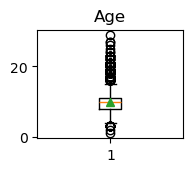

In [457]:
plt.subplot(3,3,i,title="Age").boxplot(data["Age"],showmeans=True)

la distribuzione dei non è omogenea soprattutto per granchi sotto i 3 mesi e sopra i 23 mesi i dati sono pochi. Questo mostra un età media di vita dei granchi compresa tra i 5 e 15 anno.
Andiamo ora ad analizzare  nel dettaglio la distribuzione delle altre feature.

In [456]:
data.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000
mean,1.311306,1.020893,0.349374,23.567275,10.207342,5.136546,6.795844,9.954791
std,0.300431,0.248233,0.104976,13.891201,6.275275,3.104133,3.943392,3.220967
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,1.125000,0.875000,0.287500,12.672227,5.343881,2.664853,3.713785,8.000000
50%,1.362500,1.062500,0.362500,22.792998,9.539607,4.861939,6.662133,10.000000
75%,1.537500,1.200000,0.412500,32.786197,14.273973,7.200773,9.355335,11.000000
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


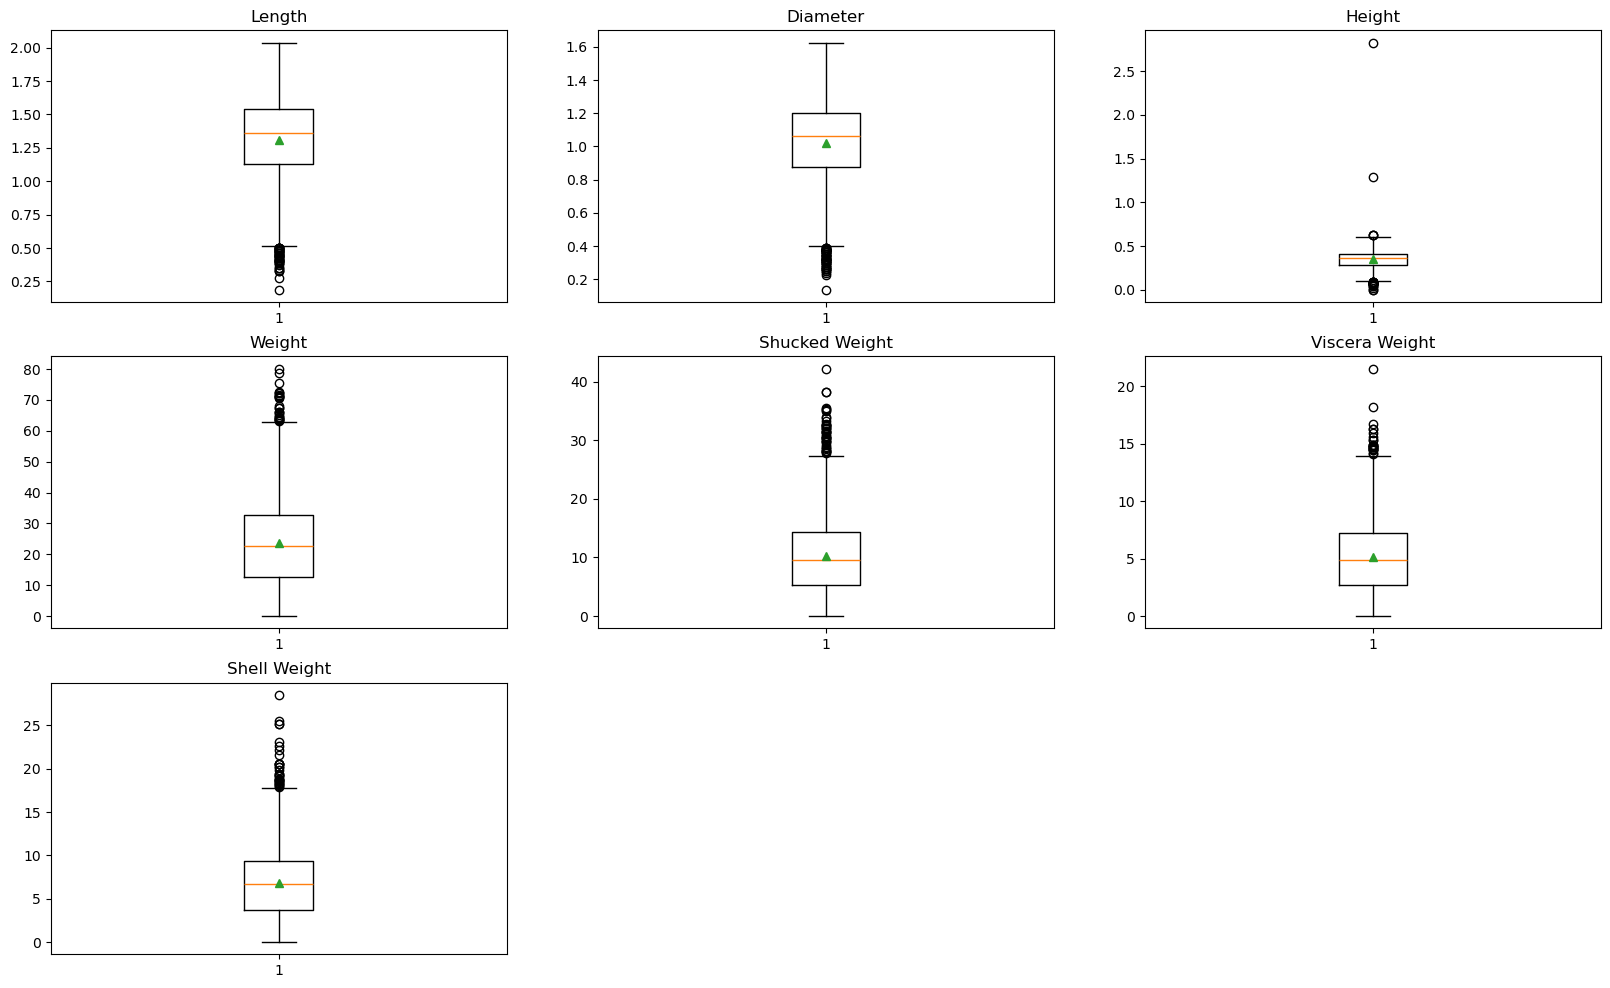

In [316]:
plt.figure(figsize=(20, 12))
for i, col in enumerate(float_vars,start=1):
    plt.subplot(3,3,i,title=col).boxplot(data[col],showmeans=True);

Dai grafici si nota che per tutte le feature sono presenti dati molto distanti dalla mediana

### correlazione tra i dati
Si procede a verificare come i dati numerici siano legati all'età dei granchi

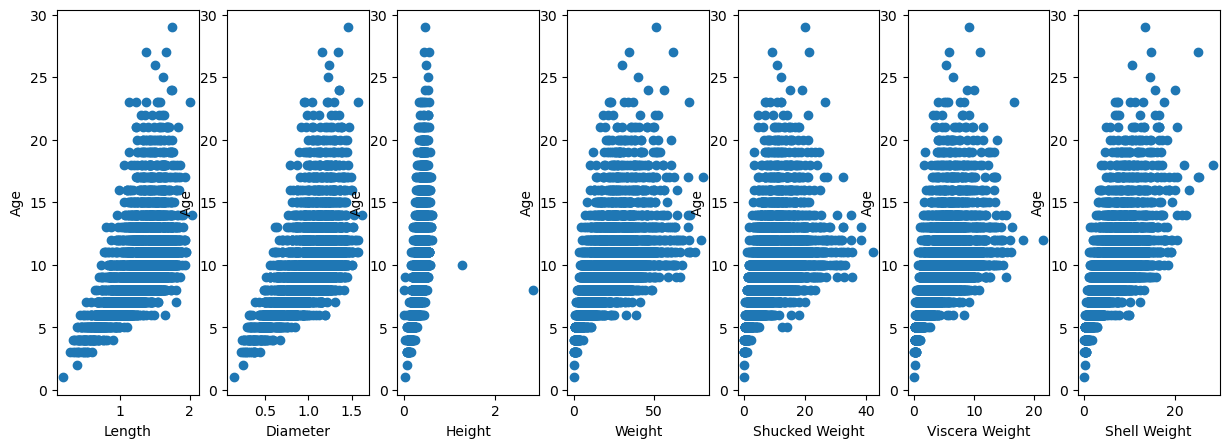

In [317]:
def age_on_numerical_subplot(data,x, y, columns, xlabels):
    n = len(columns)
    plt.figure(figsize=(15,5))
    for i in range(0,n):
      plt.subplot(x, y, i+1)
      plt.scatter(data[columns[i]], data["Age"] )
      plt.xlabel(xlabels[i])
      plt.ylabel("Age")

age_on_numerical_subplot(data, 1, len(float_vars),
                          float_vars,
                          float_vars)

come ci si aspetta al crescere delle dimensioni cresce l'età del granchio **ma questo accade con una certa regolarità fino al 10 mese**, alcuni valori successivamente **decrescono**. Inoltre vediamo per soprattutto per 'Height' ci sono dei valori che si discostano completamente da quelli in una crescita regolare andremo quindi ad eliminarli.

### dati nominali
Si procede con l'analisi dei dati di tipo nominale

In [458]:
data["Sex"].value_counts().sort_index()

Sex
F    1225
I    1233
M    1435
Name: count, dtype: int64

Sono presenti quasi un terzo di granchi senza il sesso determinato questo rende più difficile la predizione

# Preprocessamento
Eliminiamo i valori estremi  di height



In [459]:
(data["Height"] > 0.7).sum()

2

In [460]:
data_r1 = data[data["Height"] <= 0.7]

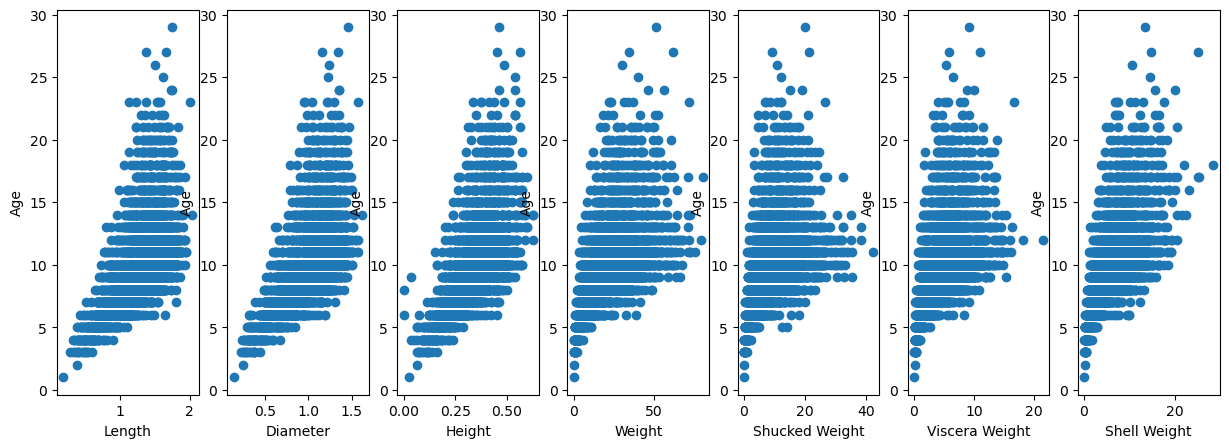

In [461]:
age_on_numerical_subplot(data_r1, 1, len(float_vars),
                          float_vars,
                          float_vars)

In [348]:
data_r1.shape

(3891, 9)

Gestione variabile 'Sex'

In [349]:
data["Sex"].unique()

['F', 'M', 'I']
Categories (3, object): ['F', 'I', 'M']

La variabile categoriaca "Sex" la convertiamo in formato numerico con codifica binaria "One-Hot"

In [462]:
from sklearn.preprocessing import OneHotEncoder

In [463]:
encoder = OneHotEncoder(drop="first", sparse_output=False)
encorder_r = pd.DataFrame(
   encoder.fit_transform(data_r1[["Sex"]]),
   columns=encoder.get_feature_names_out(["Sex"])
)

In [464]:
data_r2 = pd.concat([data_r1.drop(columns=["Sex"]), encorder_r], axis=1)

In [465]:
data_r2[data_r2.isna().any(axis=1)]

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_I,Sex_M
3891,1.0625,0.7750,0.2625,10.347568,4.507570,2.338834,2.976698,6.0,NaN,NaN
3892,0.7875,0.6125,0.2125,4.068153,1.502523,1.346601,1.417475,8.0,NaN,NaN
748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
2256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0


In [466]:
data_r2.dropna(inplace=True)

In [378]:
data_r2.filter(like="Sex").head()

,Sex_F,Sex_I,Sex_M
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,0.0,1.0,0.0


questa soluzione elimina una colonna ed esegue una correlazione migliore

avevo anche provato a togliere completamente la variabile sex, oppure a togliere i casi con valore I ma peggioro la predizione...

In [467]:
#data_r2 = data_r1.drop(columns="Sex")

In [468]:
#data_r3 = data_r3.drop(columns="Sex_I")

si procede ad isolare la colonna Age e a dividere i dati in training e validation set con il metodo **hold-out**.

In [469]:
from sklearn.model_selection import train_test_split
x = data_r2.drop(columns="Age")
y = data_r2["Age"]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=_TEST_SIZE, random_state=_RANDOM_STATE)

## Analisi coefficienti modelli


 
uso la funzione print_eval vista a lezione per calcolare e stampare le metriche d'errore:
  - l'_errore quadratico medio_, usato nella discesa del gradiente ma più difficilmente interpretabile
  - l'_errore relativo_, che indica intuitivamente la percentuale di errore del modello
  - il _coefficiente R²_, che esprime l'accuratezza con un indice tra 0 e 1

In [470]:
# MSE e R^2 sono incluse in scikit-learn
from sklearn.metrics import mean_squared_error, r2_score

# definisco l'errore relativo
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def print_eval(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    re = relative_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"   Mean squared error: {mse:.5}")
    print(f"       Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")

## Modelli
eseguo qualche prima prova esporativa per verificare i coefficienti

In [471]:
model_a = LinearRegression()
model_a.fit(x_train, y_train)
print_eval(x_val, y_val, model_a)

   Mean squared error: 4.927
       Relative error: 16.33907%
R-squared coefficient: 0.53167


In [472]:
model_b = Ridge(alpha=1)
model_b.fit(x_train, y_train)
print_eval(x_val, y_val, model_b)

   Mean squared error: 4.8955
       Relative error: 16.29923%
R-squared coefficient: 0.53466


In [473]:
model_c = Pipeline([
    ("scale", StandardScaler()),
    ("lr", LinearRegression())
])
model_c.fit(x_train, y_train)
print_eval(x_val, y_val, model_c)

   Mean squared error: 4.927
       Relative error: 16.33907%
R-squared coefficient: 0.53167


- Visualizziamo ora in un unico frame i coefficienti di tutti e tre i modelli (una riga per variabile, una colonna per modello)

In [474]:
pd.DataFrame({
    "linear": model_a.coef_,
    "ridge": model_b.coef_,
    "scaled": model_c.named_steps["lr"].coef_
}, index=x.columns)

,linear,ridge,scaled
Length,-2.453993,-1.066254,-0.735177
Diameter,6.686780,5.360665,1.659033
Height,10.740262,8.545452,1.030427
Weight,0.308993,0.313200,4.285137
Shucked Weight,-0.677507,-0.686441,-4.237281
Viscera Weight,-0.396296,-0.389767,-1.231280
Shell Weight,0.255986,0.278090,1.006553
Sex_I,-0.043638,-0.048540,-0.020373
Sex_M,-0.035413,-0.037612,-0.017049


da una prima analisi vediamo che il peso del granchio e il peso del granchio senza guscio determinano notevolmento il risultato finale.
Usiamo quindi la Regressione Lasso usando la regolarizzazione L1 dove le variabili meno importanti vengono ridotte a zero per filtrare le variabili poco utili e quelle rindondanti

In [475]:
from sklearn.linear_model import Lasso
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", Lasso(alpha=1))
])
model.fit(x_train, y_train)

Pipeline(steps=[('scale', StandardScaler()), ('regr', Lasso(alpha=1))])

In [476]:
pd.Series(model.named_steps["regr"].coef_, x.columns)

Length            0.000000
Diameter          0.000000
Height            0.380374
Weight            0.000000
Shucked Weight    0.000000
Viscera Weight    0.000000
Shell Weight      0.654675
Sex_I            -0.000000
Sex_M             0.000000
dtype: float64

In [395]:
print_eval(x_val, y_val, model)

   Mean squared error: 7.0444
       Relative error: 21.12446%
R-squared coefficient: 0.29399


l'accuratezza peggiora quindi provo a calare il peso della regolarizzazione

In [477]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", Lasso(alpha=0.2))
])
model.fit(x_train, y_train)

Pipeline(steps=[('scale', StandardScaler()), ('regr', Lasso(alpha=0.2))])

In [397]:
pd.Series(model.named_steps["regr"].coef_, x.columns)

Length            0.000000
Diameter          0.000000
Height            0.749930
Weight            0.000000
Shucked Weight   -0.411179
Viscera Weight   -0.000000
Shell Weight      1.569147
Sex_F             0.000000
Sex_I            -0.000000
Sex_M             0.000000
dtype: float64

In [398]:
print_eval(x_val, y_val, model)

   Mean squared error: 5.9343
       Relative error: 18.18161%
R-squared coefficient: 0.40525


l'errore cala ma è sempre maggiore di quello ottenuto nei precedenti modelli

proviamo con la regressione elastic net, che combina la regressione ridge e lasso

In [478]:
from sklearn.linear_model import ElasticNet
model = Pipeline([
    ("scale",  StandardScaler()),
    ("regr", ElasticNet(alpha=0.2, l1_ratio=0.1))
])
model.fit(x_train, y_train)
print_eval(x_val, y_val, model)

   Mean squared error: 5.7791
       Relative error: 17.34963%
R-squared coefficient: 0.45068


il risultato migliora ma è ancora scarso, questo mi indica che tutte le feture sono importanti. Ora utilizziamo un modello elastic net con regressione polinomiale provando più gradi

In [482]:
def poly_std_elasticnet(degree):
    return Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("std",  StandardScaler()),
        ("regr", ElasticNet(alpha=0.5, l1_ratio=0.2))
    ])

In [483]:
model = poly_std_elasticnet(2)
%time model.fit(x_train, y_train)
print_eval(x_val, y_val, model)

CPU times: total: 46.9 ms
Wall time: 24.3 ms
   Mean squared error: 5.9857
       Relative error: 18.04011%
R-squared coefficient: 0.43103


In [484]:
model = poly_std_elasticnet(5)
%time model.fit(x_train, y_train)
print_eval(x_val, y_val, model)

CPU times: total: 1.62 s
Wall time: 1.43 s
   Mean squared error: 5.904
       Relative error: 17.95916%
R-squared coefficient: 0.4388


usiamo regressione con funzioni kernel per ridurre i tempi simulando una regressione polinomiale di grado 5 senza generare tutte le variabili

In [485]:
from sklearn.kernel_ridge import KernelRidge
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="poly", degree=5))
])
%time model.fit(x_train, y_train)
print_eval(x_val, y_val, model)

CPU times: total: 906 ms
Wall time: 551 ms
   Mean squared error: 5.1211
       Relative error: 15.61376%
R-squared coefficient: 0.51322


Per il momento è il migliore risultato ottenuto usiamo GridSearchCV per utilizzare i parametri migliori usando la cross validation a 3 fold

In [498]:
from sklearn.model_selection import GridSearchCV,KFold
kf = KFold(5, shuffle=True, random_state=42)

In [499]:
model = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr",  KernelRidge())
])

In [500]:
grid = {
    "poly__degree": [2, 3],      # <- grado polinomio
    "regr__alpha":  [0.1, 1, 10] # <- regolarizzazione
}

In [504]:
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(x_train, y_train);
gs.best_params_

{'poly__degree': 3, 'regr__alpha': 1}

In [505]:
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,param_regr__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.201929,0.006255,0.014681,0.003519,3,1,"{'poly__degree': 3, 'regr__alpha': 1}",-8.583464,-9.469497,-7.606208,-10.126134,-10.350888,-9.227238,1.017003,1
3,0.208284,0.008554,0.014184,0.002978,3,0.1,"{'poly__degree': 3, 'regr__alpha': 0.1}",-8.615680,-9.482843,-7.590998,-10.089083,-10.363972,-9.228515,1.015042,2
1,0.173230,0.017915,0.008950,0.002378,2,1,"{'poly__degree': 2, 'regr__alpha': 1}",-8.557979,-9.460445,-7.634730,-10.171890,-10.340848,-9.233178,1.016926,3
0,0.171984,0.009629,0.009670,0.000823,2,0.1,"{'poly__degree': 2, 'regr__alpha': 0.1}",-8.594304,-9.473348,-7.595145,-10.139442,-10.371097,-9.234667,1.026173,4
5,0.201497,0.005199,0.013802,0.003126,3,10,"{'poly__degree': 3, 'regr__alpha': 10}",-8.531008,-9.457765,-7.662212,-10.201157,-10.339911,-9.238411,1.017165,5
2,0.178956,0.006571,0.007309,0.002633,2,10,"{'poly__degree': 2, 'regr__alpha': 10}",-8.516069,-9.467546,-7.688666,-10.213684,-10.344233,-9.246040,1.014860,6


In [506]:
print_eval(x_val, y_val, gs)

   Mean squared error: 103.26
       Relative error: 107.16151%
R-squared coefficient: -8.8149


In [507]:
model = Pipeline([
    ("scale", None),   # uso None come segnaposto
    ("regr",  Ridge())
])
grid = {
    # scale = standardizzazione oppure nulla
    "scale": [None, StandardScaler()],
    "regr__alpha": [0.1, 1, 10]
}
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(x_train, y_train);
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regr__alpha,param_scale,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.003706,0.002196,0.002415,0.001357,1,StandardScaler(),"{'regr__alpha': 1, 'scale': StandardScaler()}",0.571075,0.485894,0.546053,0.558008,0.444863,0.521179,0.048029,1
0,0.002792,0.000746,0.001795,0.000746,0.1,None,"{'regr__alpha': 0.1, 'scale': None}",0.570704,0.486713,0.547184,0.556975,0.444209,0.521157,0.048005,2
1,0.004400,0.000489,0.002588,0.001240,0.1,StandardScaler(),"{'regr__alpha': 0.1, 'scale': StandardScaler()}",0.570569,0.486271,0.547422,0.557285,0.443828,0.521075,0.048236,3
2,0.004095,0.001280,0.002848,0.002272,1,None,"{'regr__alpha': 1, 'scale': None}",0.570673,0.488318,0.543678,0.554104,0.445672,0.520489,0.046516,4
5,0.005018,0.000007,0.000000,0.000000,10,StandardScaler(),"{'regr__alpha': 10, 'scale': StandardScaler()}",0.571723,0.481635,0.535162,0.558577,0.447716,0.518963,0.047085,5
4,0.001004,0.002008,0.002005,0.002456,10,None,"{'regr__alpha': 10, 'scale': None}",0.561693,0.483635,0.531129,0.537256,0.437931,0.510329,0.044159,6


In [508]:
gs.score(x_val, y_val)

0.5315933300869138

regressione con alberi

In [509]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
model = DecisionTreeRegressor(max_depth=6, random_state=42)
model.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=6, random_state=42)

In [510]:
print_eval(x_val, y_val, model)

   Mean squared error: 5.7685
       Relative error: 16.40534%
R-squared coefficient: 0.45168


In [511]:
features = x_val.columns.tolist()
print(export_text(model, feature_names=features, max_depth=5))

|--- Shell Weight <= 4.67
|   |--- Shell Weight <= 1.92
|   |   |--- Shell Weight <= 0.75
|   |   |   |--- Shucked Weight <= 0.20
|   |   |   |   |--- Shell Weight <= 0.06
|   |   |   |   |   |--- value: [1.00]
|   |   |   |   |--- Shell Weight >  0.06
|   |   |   |   |   |--- Weight <= 0.43
|   |   |   |   |   |   |--- value: [3.67]
|   |   |   |   |   |--- Weight >  0.43
|   |   |   |   |   |   |--- value: [3.00]
|   |   |   |--- Shucked Weight >  0.20
|   |   |   |   |--- Viscera Weight <= 0.39
|   |   |   |   |   |--- Weight <= 1.89
|   |   |   |   |   |   |--- value: [4.26]
|   |   |   |   |   |--- Weight >  1.89
|   |   |   |   |   |   |--- value: [5.33]
|   |   |   |   |--- Viscera Weight >  0.39
|   |   |   |   |   |--- Diameter <= 0.48
|   |   |   |   |   |   |--- value: [5.18]
|   |   |   |   |   |--- Diameter >  0.48
|   |   |   |   |   |   |--- value: [4.20]
|   |   |--- Shell Weight >  0.75
|   |   |   |--- Shell Weight <= 1.12
|   |   |   |   |--- Diameter <= 0.44
|   |  

## Random Forest
Addestro più alberi in un sottoinsieme delle feature

In [512]:
from sklearn.ensemble import RandomForestRegressor

In [513]:
%%time
rfm = RandomForestRegressor(max_samples=0.2, max_features="sqrt", n_estimators=200, max_depth=None, n_jobs=-1)
rfm.fit(x_train, y_train)

CPU times: total: 703 ms
Wall time: 423 ms


RandomForestRegressor(max_features='sqrt', max_samples=0.2, n_estimators=200,
                      n_jobs=-1)

In [514]:
print_eval(x_val, y_val, rfm)

   Mean squared error: 4.738
       Relative error: 15.31108%
R-squared coefficient: 0.54964


In [515]:
rfm.feature_importances_

array([0.08656148, 0.12121594, 0.13694708, 0.146369  , 0.1282055 ,
       0.11819194, 0.24075985, 0.01070941, 0.01103981])

In [516]:
pd.Series(rfm.feature_importances_, index=features).sort_values(ascending=False)

Shell Weight      0.240760
Weight            0.146369
Height            0.136947
Shucked Weight    0.128206
Diameter          0.121216
Viscera Weight    0.118192
Length            0.086561
Sex_M             0.011040
Sex_I             0.010709
dtype: float64

la feature più importante è il peso della conchiglia

## LightGBM: 
Gradient Boosted Machine

In [517]:
from lightgbm import LGBMRegressor

In [518]:
%%time
lgbm = LGBMRegressor()
lgbm.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1290
[LightGBM] [Info] Number of data points in the train set: 2592, number of used features: 9
[LightGBM] [Info] Start training from score 9.969522
CPU times: total: 188 ms
Wall time: 100 ms


LGBMRegressor()

In [519]:
print_eval(x_val, y_val, lgbm)

   Mean squared error: 4.8513
       Relative error: 15.49891%
R-squared coefficient: 0.53886


## XGBoost

- La libreria `xgboost` fornisce un'implementazione dell'omonimo algoritmo (_eXtreme Gradient Boosting_)

In [520]:
import xgboost
print(xgboost.__version__)

1.1.0


In [521]:
from xgboost import XGBRegressor

In [522]:
%%time
xgbm = XGBRegressor(objective='reg:squarederror', reg_alpha=0.0, reg_lambda=1.0, n_estimators=200, verbose_eval=True)
xgbm.fit(x_train, y_train)

[23:55:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: total: 1.41 s
Wall time: 472 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.0, reg_lambda=1.0, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbose_eval=True,
             verbosity=None)

In [523]:
print_eval(x_val, y_val, xgbm)

   Mean squared error: 5.4372
       Relative error: 16.15122%
R-squared coefficient: 0.48318


In [524]:
pd.Series(xgbm.feature_importances_, index=features).sort_values(ascending=False)

Shell Weight      0.515785
Shucked Weight    0.108453
Weight            0.072374
Height            0.071711
Viscera Weight    0.061207
Diameter          0.054231
Sex_M             0.045608
Sex_I             0.037056
Length            0.033575
dtype: float32